In [1]:
import requests
contracts_url = 'https://www.politicalalertengine.com/api/contracts/all'

r = requests.get(contracts_url)

In [2]:
contracts = r.json()

In [3]:
prices_url = 'https://www.politicalalertengine.com/api/analytics/dataByIds/%d'

prices = requests.get(prices_url % 4390).json()

In [4]:
import pandas as pd
df = pd.DataFrame(prices)

In [5]:
import numpy as np
df['date'] = pd.to_datetime(df['date'])
df['lastTradePrice'] = df['lastTradePrice'].astype(np.float64)

In [6]:
keep_cols = ['date', 'lastTradePrice']
model_df = df[keep_cols].set_index('date')

In [30]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(model_df['lastTradePrice'][:100])

print ("ADF = " + str(adf_test[0]))
print ("p-value = " +str(adf_test[1]))

ADF = -3.4169125189723015
p-value = 0.010395660312008663


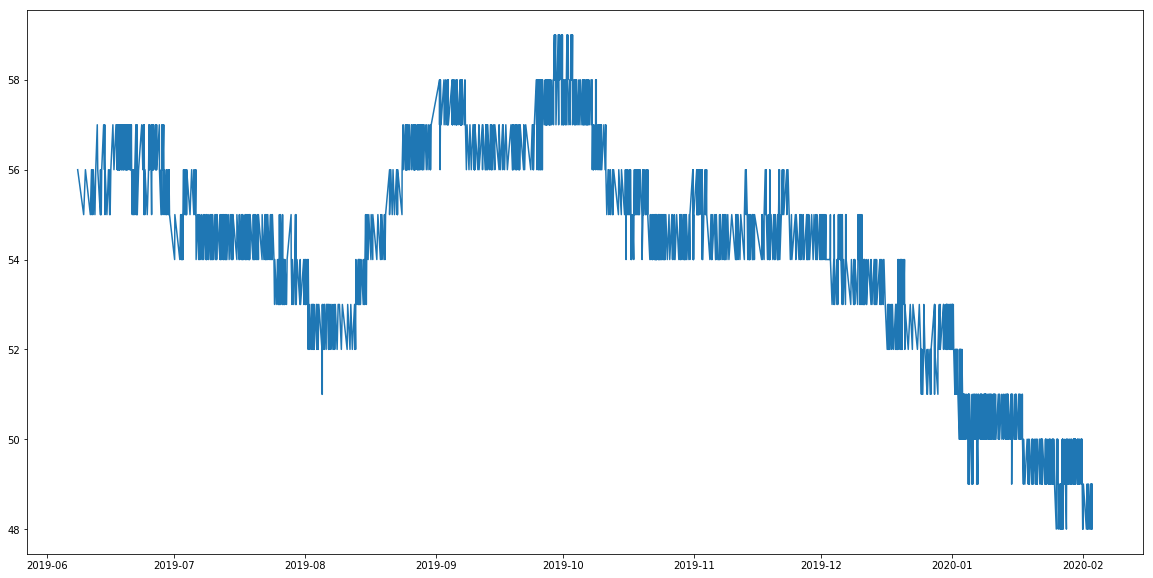

In [28]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(df['date'][:2000],df['lastTradePrice'][:2000])

In [34]:
# rolling stationarity check, count how many times data is stationary and how many it isn't

# length of window
window = 100

stationary = []
non_stationary = []

for i in range(window, len(model_df)):
    adf_test = adfuller(model_df['lastTradePrice'][i-window:i])
    p_val = adf_test[1]
    
    if p_val < 0.10:
        stationary.append(model_df.index[i])
    else:
        non_stationary.append(model_df.index[i])
    

In [ ]:
#def rolling_test(price_list, index, window):
#    if window > index:
#        return None
#    return adfuller(price_list[index - window, index])[1]
#model_df = model_df.reset_index()
#model_df['pval'] = model_df.apply(rolling_test(model_df['lastTradePrice'], model))

In [69]:
# try to exit at the next price change
#model_df = model_df.reset_index()
returns = [0]
for i in stationary:
    index = model_df[model_df.date==i].index[0]
    rolling_mean = np.mean(model_df['lastTradePrice'][index-100:index])
    current_price = float(model_df[model_df.date==i]['lastTradePrice'])
    next_price = float(model_df[model_df.index==index+1]['lastTradePrice'])
    if current_price < rolling_mean:
        # buy now sell at next price
        profit = next_price - current_price
        val =returns[-1] + profit
        returns.append(val)
    else:
        # short
        profit = current_price - next_price
        val = returns[-1] + profit
        returns.append(val)
        

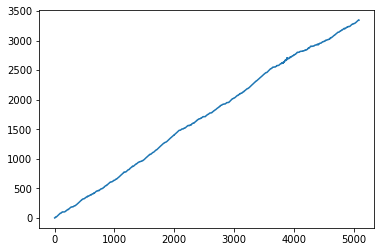

In [70]:
plt.plot(returns)

In [73]:
count = 0
for i in range(len(returns) - 1):
    if returns[i] < returns[i+1]:
        count +=1

In [76]:
count/len(stationary)

0.7664047151277014

In [85]:
def is_stationary(x):
    if x in stationary:
        return 'r'
    else:
        return 'b'
model_df['isStationary'] = model_df['date'].apply(is_stationary)
        

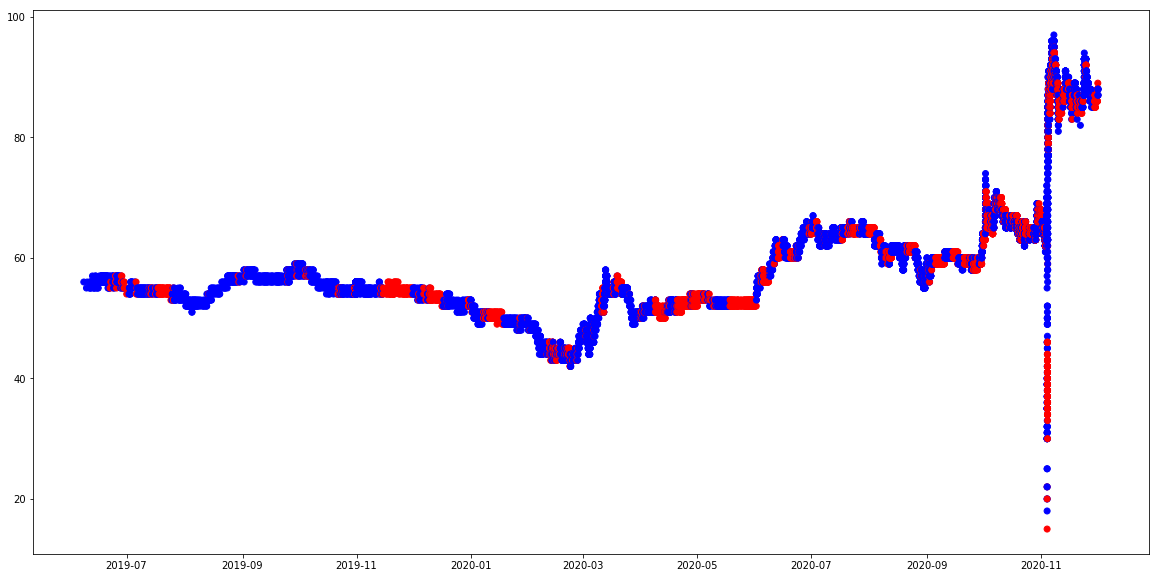

In [100]:
fig = plt.figure(figsize=(20,10))
plt.scatter(model_df['date'], y= model_df['lastTradePrice'], c = model_df["isStationary"])

In [91]:
len(stationary)/len(model_df)

0.3413816230717639

In [96]:
len(model_df[model_df['isStationary'] == 'r'])

5090

In [97]:
len(stationary)

5090